In [67]:
%matplotlib inline
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy import io
import pickle

# Own code
sys.path.append("../")
from utils.data_utils import generate_contemp_matrices, transformation, standardize
from utils.tvp_models import TVPVARModel, tvp_ar_contemp, tvp_ar_non_contemp

# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

In [68]:
# Set M and standardization

M = 3
standardization = False

In [69]:
transform = True

ds = pd.read_csv("../data/fred_qd.csv")
gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform, scale=1)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform, scale=1)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform, scale=1)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform, scale=1)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform, scale=1)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform, scale=1)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform, scale=1)

# Start due to transformation

lag = 1

if M == 3:

    series = [gdp[lag:], cpi[lag:], fedfund[lag:]]
    
elif M == 7:
    
    series = [gdp[lag:], cpi[lag:], fedfund[lag:],compi[lag:],borrowings[lag:],sp500[lag:],m2[lag:]]
    

if standardization:
    
    series = standardize(series, train = 243-25)

series_total = np.array(series)

y_matrix_contemp, X_matrix_contemp = generate_contemp_matrices(244, M, 1, series_total)

# Lasso 

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "lasso_alternative"
train = T - 25

msfe, alpl, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=200)

### Parameter -> $a_{0}$

In [ ]:
def calculate_derivative_lasso_a0(iteration, parameter_value):
    
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 100

    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":parameter_value+error,"b0_lasso":1e-3}
    prior_parameters_minus = {"a0_lasso":parameter_value-error,"b0_lasso":1e-3}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 2
interval = 64

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_a0, a0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 256) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "a0_lasso"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_lasso_b0(iteration, parameter_value):
    
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":1e-3,"b0_lasso":parameter_value+error}
    prior_parameters_minus = {"a0_lasso":1e-3,"b0_lasso":parameter_value-error}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 0.5
interval = 64

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "b0_lasso"
start = 1e-3
finish = 0.5
interval = 64

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# SVSS

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "svss"

train = T - 25

prior_paramters = {"g0":1e-2,"h0":1e-2,"pi0":0.5}

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=75, prior_parameters=prior_paramters)

### Parameter -> $g_{0}$

In [ ]:
def calculate_derivative_svss_g0(iteration, parameter_value):
    
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":parameter_value+error,"h0":1e-2, "pi0":0.5}
    prior_parameters_minus = {"g0":parameter_value-error,"h0":1e-2, "pi0":0.5}
    
    msfe_plus, alpl_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, apl_min, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-2
finish = 1
interval = 64

g0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_g0, g0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline+
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "svss"
parameter = "g0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_std.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $h_{0}$

In [ ]:
def calculate_derivative_svss_h0(iteration, parameter_value):
    
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":1e-2,"h0":parameter_value+error, "pi0":0.5}
    prior_parameters_minus = {"g0":1e-2,"h0":parameter_value-error, "pi0":0.5}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-2
finish = 1.5e-2
interval = 64

h0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_h0, h0_set)

In [ ]:
result[44,0]

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

threshold = 64

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:threshold,0].min(), result[:threshold,0].max(), 528)

spl = make_interp_spline(result[:threshold,0], result[:threshold,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "svss"
parameter = "h0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_std.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# Horseshoe

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "horseshoe"
train = T - 25

prior_parameters = {"a0":5, "b0":1}

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100, prior_parameters=prior_parameters)

### Parameter -> $a_{0}$

In [70]:
def calculate_derivative_horseshoe_a0(iteration, parameter_value):
    
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":parameter_value+error,"b0":1}
    prior_parameters_minus = {"a0":parameter_value-error,"b0":1}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [71]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 4
finish = 5
interval = 128

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_a0, a0_set)

Run: 31 -> Derivative: 1.6597911857792504e-05
Run: 29 -> Derivative: 1.2883206874616918e-05
Run: 27 -> Derivative: 9.040730859805764e-06
Run: 25 -> Derivative: 5.063785137914076e-06
Run: 23 -> Derivative: 9.4732502743391e-07
Run: 21 -> Derivative: -3.318242636469507e-06
Run: 19 -> Derivative: -7.735812343185977e-06
Run: 15 -> Derivative: -1.705176779411353e-05
Run: 13 -> Derivative: -2.1963798988305103e-05
Run: 17 -> Derivative: -1.2312661666038432e-05
Run: 9 -> Derivative: -3.233558146893573e-05
Run: 11 -> Derivative: -2.7056115521632946e-05
Run: 7 -> Derivative: -3.784635846833215e-05
Run: 5 -> Derivative: -4.352882003839229e-05
Run: 3 -> Derivative: -4.942191773633318e-05
Run: 1 -> Derivative: -5.553722951971405e-05
Run: 30 -> Derivative: 1.4757843602846675e-05
Run: 32 -> Derivative: 1.8408042822478095e-05
Run: 28 -> Derivative: 1.0979211754004879e-05
Run: 26 -> Derivative: 7.069666285047161e-06
Run: 24 -> Derivative: 3.0237490159813224e-06
Run: 22 -> Derivative: -1.1658176265155677

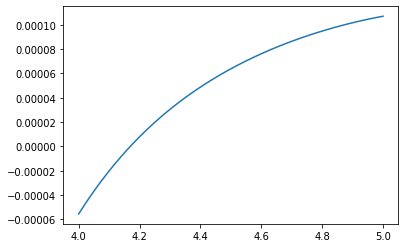

In [72]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [73]:
prior = "horseshoe"
parameter = "a0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [77]:
def calculate_derivative_horseshoe_b0(iteration, parameter_value):
    
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":4,"b0":parameter_value+error}
    prior_parameters_minus = {"a0":4,"b0":parameter_value-error}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1
finish = 1.25
interval = 128

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_b0, b0_set)

Run: 1 -> Derivative: 2.6655352790690587e-05
Run: 25 -> Derivative: 4.4712004601246665e-05
Run: 29 -> Derivative: 4.794076616572285e-05
Run: 13 -> Derivative: 3.538844077820878e-05
Run: 19 -> Derivative: 3.9975214064683415e-05
Run: 5 -> Derivative: 2.95128754160004e-05
Run: 7 -> Derivative: 3.0963097299988265e-05
Run: 15 -> Derivative: 3.690101823362268e-05
Run: 31 -> Derivative: 4.95855804364023e-05
Run: 21 -> Derivative: 4.15369151400271e-05
Run: 9 -> Derivative: 3.240951499792097e-05
Run: 11 -> Derivative: 3.389099736731871e-05
Run: 23 -> Derivative: 4.3115900452012754e-05
Run: 27 -> Derivative: 4.63232427950044e-05
Run: 17 -> Derivative: 3.843021832810373e-05
Run: 3 -> Derivative: 2.8076216282296174e-05
Run: 2 -> Derivative: 2.736441999149533e-05
Run: 26 -> Derivative: 4.551543215615897e-05
Run: 14 -> Derivative: 3.6142744713191295e-05
Run: 6 -> Derivative: 3.02361669646636e-05
Run: 30 -> Derivative: 4.876098175909601e-05
Run: 16 -> Derivative: 3.7663344039199786e-05
Run: 20 -> Der

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "horseshoe"
parameter = "b0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)